# Time Series Forecasting - Multivariable Time Series Models for Stock Market Prediction

## import Packages

In [79]:
import math 
import numpy as np 
import pandas as pd 
from datetime import date, timedelta, datetime 
from pandas.plotting import register_matplotlib_converters 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import seaborn as sns 
import mysql.connector as mysql
import yfinance as yf


## Change the indicators

In [80]:
#hyperparameters
# epochs  = [10,100,1000]
# units = [10,50,128]
epoch = 10
unit = 128

## Load the Time Series Data use Yahoo finance

In [100]:

start_date = '2017-01-01'

end_date = '2021-12-31'
symbol_dataset = 'GGRM.jk'

# arr_end_date = ['2021-12-31','2017-12-31', '2017-03-30']
# arr_symbol_dataset = ['UNVR.jk', 'GGRM.jk', 'PSDN.jk']

# jumlah_pengujian = 0
# for index_dataset in arr_symbol_dataset:
#     for index_end_date in arr_end_date:
#         for epoch in epochs:
#             for unit in units: 
                
#                 jumlah_pengujian+=1
#                 df = yf.download(index_dataset, start=start_date, end=index_end_date)
#                 if df.shape[0]>=1250:
#                     term_status = "long"
#                 elif df.shape[0]>=250:
#                     term_status = "mid"
#                 else:
#                     term_status = "short"
                
#                 print("pengujian ke-" + str(jumlah_pengujian))
#                 print("Data Saham = " + index_dataset + term_status)
#                 print("Start = " + start_date)
#                 print("End = " + index_end_date)
                
#                 print("epochs = " + str(epoch))
#                 print("unit = " + str(unit))
                
#                 print("==================================")

        



df = yf.download(symbol_dataset, start=start_date, end=end_date)
if df.shape[0]>=1250:
    term_status = "long"
elif df.shape[0]>=250:
    term_status = "mid"
else:
    term_status = "short"
                


# # Create a quick overview of the dataset
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,63900.0,63900.0,63900.0,63900.0,53820.609375,0
2017-01-03,63650.0,64350.0,63100.0,63300.0,53315.250000,340700
2017-01-04,63400.0,64450.0,62300.0,63200.0,53231.023438,578800
2017-01-05,63200.0,65600.0,63200.0,65600.0,55252.457031,1023100
2017-01-06,65450.0,65450.0,63900.0,64425.0,54262.796875,339100
...,...,...,...,...,...,...
2021-12-24,30625.0,30625.0,30500.0,30525.0,30522.832031,294700
2021-12-27,30525.0,30800.0,30475.0,30675.0,30672.820312,390700
2021-12-28,30675.0,30850.0,30650.0,30650.0,30647.822266,406900


# Preprocessing

## Cek and Imputation missing value

In [101]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [102]:
# jika ada data yang null, run this code

# df = df.fillna(df.mean())

In [103]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,63900.0,63900.0,63900.0,63900.0,53820.609375,0
2017-01-03,63650.0,64350.0,63100.0,63300.0,53315.250000,340700
2017-01-04,63400.0,64450.0,62300.0,63200.0,53231.023438,578800
2017-01-05,63200.0,65600.0,63200.0,65600.0,55252.457031,1023100
2017-01-06,65450.0,65450.0,63900.0,64425.0,54262.796875,339100
...,...,...,...,...,...,...
2021-12-24,30625.0,30625.0,30500.0,30525.0,30522.832031,294700
2021-12-27,30525.0,30800.0,30475.0,30675.0,30672.820312,390700
2021-12-28,30675.0,30850.0,30650.0,30650.0,30647.822266,406900


<Figure size 432x288 with 0 Axes>

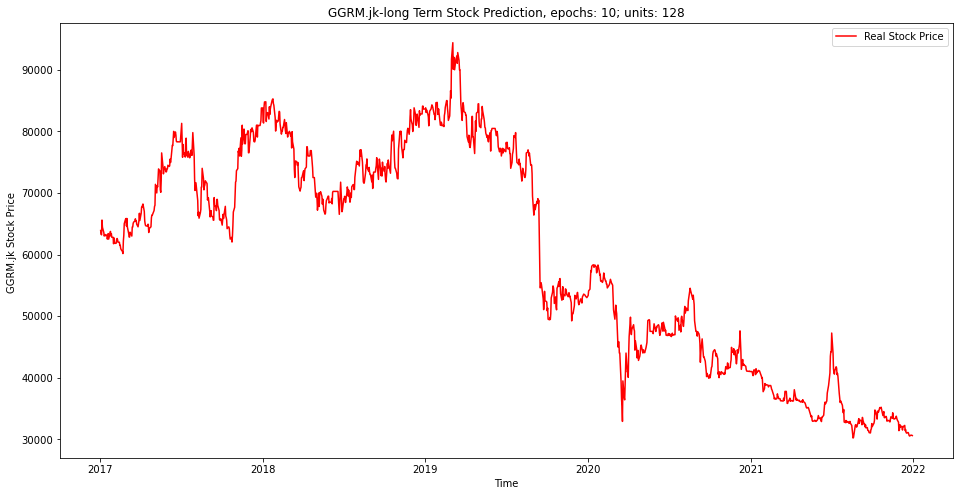

In [104]:
plt.figure()
plt.subplots(figsize=(16, 8))
plt.plot(df['Close'], color = 'red', label = 'Real Stock Price')
plt.title(symbol_dataset +"-"+ term_status +' Term Stock Prediction, epochs: '+ str(epoch) +'; units: '+str(unit))
plt.xlabel('Time')
plt.ylabel(symbol_dataset +' Stock Price ')
plt.legend()

## Feature Selection and Scaling

In [105]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# Daftar Fitur yang digunakan
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume']

print('FEATURE LIST')
print([f for f in FEATURES])

# Buat kumpulan data dengan fitur dan filter data ke daftar FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# Kami menambahkan kolom prediksi dan menetapkan nilai dummy untuk menyiapkan data untuk penskalaan
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the dataframe
data_filtered_ext

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2017-01-02,63900.0,63900.0,63900.0,63900.0,0,63900.0
2017-01-03,64350.0,63100.0,63650.0,63300.0,340700,63300.0
2017-01-04,64450.0,62300.0,63400.0,63200.0,578800,63200.0
2017-01-05,65600.0,63200.0,63200.0,65600.0,1023100,65600.0
2017-01-06,65450.0,63900.0,65450.0,64425.0,339100,64425.0
...,...,...,...,...,...,...
2021-12-24,30625.0,30500.0,30625.0,30525.0,294700,30525.0
2021-12-27,30800.0,30475.0,30525.0,30675.0,390700,30675.0
2021-12-28,30850.0,30650.0,30675.0,30650.0,406900,30650.0


In [106]:
# Dapatkan jumlah baris dalam data
nrows = data_filtered.shape[0]
# print(nrows)

# Convert the data ke numpy values
np_data_unscaled = np.array(data_filtered)
# print(np_data_unscaled)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Membuat scaler terpisah yang berfungsi pada satu kolom untuk prediksi penskalaan
scaler_pred = MinMaxScaler(feature_range=(0,1))
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(1261, 5)


## Transforming the Data

In [107]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 1

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(1008, 1, 5) (1008,)
(252, 1, 5) (252,)
0.5155763239875388
0.5155763239875388


1009

## Train the Multivariate Prediciton Model

In [108]:
# Configure the neural network model
model = Sequential()
model.add(LSTM(unit, return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(Dense(1))


# Compile the model
model.compile(optimizer='adam', loss='mse')

In [109]:
# Training the model
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=16, 
                    epochs=epoch,
                    validation_data=(x_test, y_test)
                   )
                    
                    #callbacks=[early_stop])

Epoch 1/10
63/63 [==============================] - 2s 8ms/step - loss: 0.0692 - val_loss: 0.0204
Epoch 2/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0125
Epoch 3/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0074
Epoch 4/10
63/63 [==============================] - 0s 2ms/step - loss: 0.0011 - val_loss: 0.0043
Epoch 5/10
63/63 [==============================] - 0s 2ms/step - loss: 8.0209e-04 - val_loss: 0.0028
Epoch 6/10
63/63 [==============================] - 0s 2ms/step - loss: 6.8714e-04 - val_loss: 0.0020
Epoch 7/10
63/63 [==============================] - 0s 2ms/step - loss: 6.5537e-04 - val_loss: 0.0014
Epoch 8/10
63/63 [==============================] - 0s 2ms/step - loss: 6.3638e-04 - val_loss: 0.0014
Epoch 9/10
63/63 [==============================] - 0s 2ms/step - loss: 6.4314e-04 - val_loss: 0.0012
Epoch 10/10
63/63 [==============================] - 0s 2ms/step - loss: 6.3749e-04 - val_loss: 0.

In [110]:
# Plot training & validation loss values
# fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
# sns.lineplot(data=history.history["loss"])
# plt.title("Model loss")
# plt.ylabel("Loss")
# plt.xlabel("Epoch")
# ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
# plt.legend(["Train", "Test"], loc="upper left")
# plt.grid()
# plt.show()

In [111]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

8/8 [==============================] - 1s 1ms/step


In [112]:
y_test.reshape(-1,1)

array([[0.1732866 ],
       [0.16939252],
       [0.16861371],
       [0.16939252],
       [0.1682243 ],
       [0.1682243 ],
       [0.16394081],
       [0.15809969],
       [0.15809969],
       [0.17211838],
       [0.17211838],
       [0.16043614],
       [0.17523364],
       [0.16510903],
       [0.16510903],
       [0.17095016],
       [0.17095016],
       [0.16939252],
       [0.16939252],
       [0.16588785],
       [0.15654206],
       [0.15147975],
       [0.15303738],
       [0.13590343],
       [0.11721184],
       [0.12461059],
       [0.13785047],
       [0.13434579],
       [0.13395639],
       [0.13512461],
       [0.13395639],
       [0.13356698],
       [0.12928349],
       [0.13278816],
       [0.13278816],
       [0.12889408],
       [0.12344237],
       [0.12149533],
       [0.11760125],
       [0.10708723],
       [0.09890966],
       [0.10124611],
       [0.1008567 ],
       [0.09813084],
       [0.09968847],
       [0.11176012],
       [0.105919  ],
       [0.104

In [113]:
# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

In [114]:
print(f'Jumlah data y_train: {y_train.shape[0]}')
print(f'Jumlah data y_pred: {y_pred.shape[0]}')
print(f'Jumlah data y_test_unscaled: {y_test_unscaled.shape[0]}')

Jumlah data y_train: 1008
Jumlah data y_pred: 252
Jumlah data y_test_unscaled: 252


## Evaluate Model performance

In [115]:
# Root Mean Square Error (RMSE)
MSE = mean_squared_error(y_test_unscaled, y_pred)
RMSE = math.sqrt(MSE)
RMSE = np.round(RMSE, 2)
print(f'Root Mean Square Error (RMSE): {RMSE}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
MAE = np.round(MAE, 2)
print(f'Median Absolute Error (MAE): {MAE}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
MAPE = np.round(MAPE, 2)
print(f'Mean Absolute Percentage Error (MAPE): {MAPE} %')

Root Mean Square Error (RMSE): 2121.98
Median Absolute Error (MAE): 1981.28
Mean Absolute Percentage Error (MAPE): 5.76 %


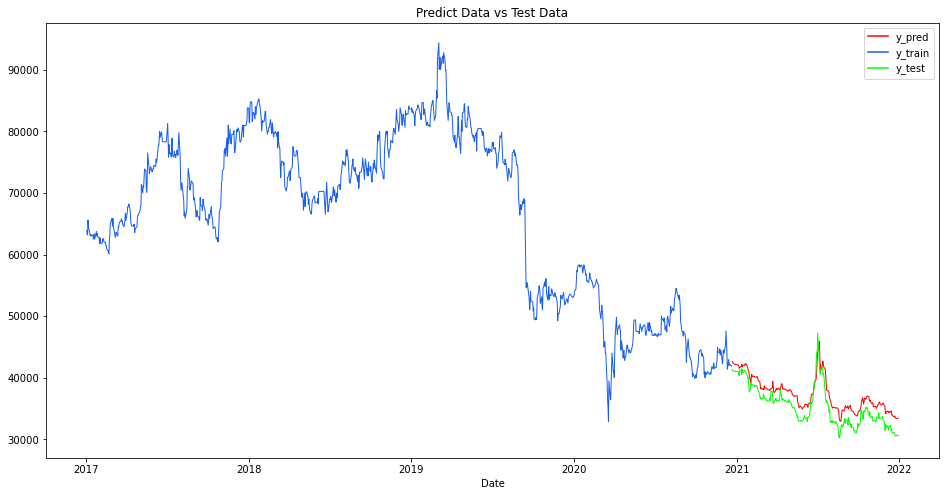

In [116]:
# The date from which on the date is displayed
display_start_date = start_date


# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
# valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Predict Data vs Test Data")

sns.set_palette(["#FF0000", "#1960EF", "#00FF00"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
# df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
# ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
# plt.savefig("../results/LSTM/plots/" + symbol_dataset +'_LSTM-'+ 
#                             term_status + '_e='+ str(epoch) +'_u='+ str(unit) + '.pdf')
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

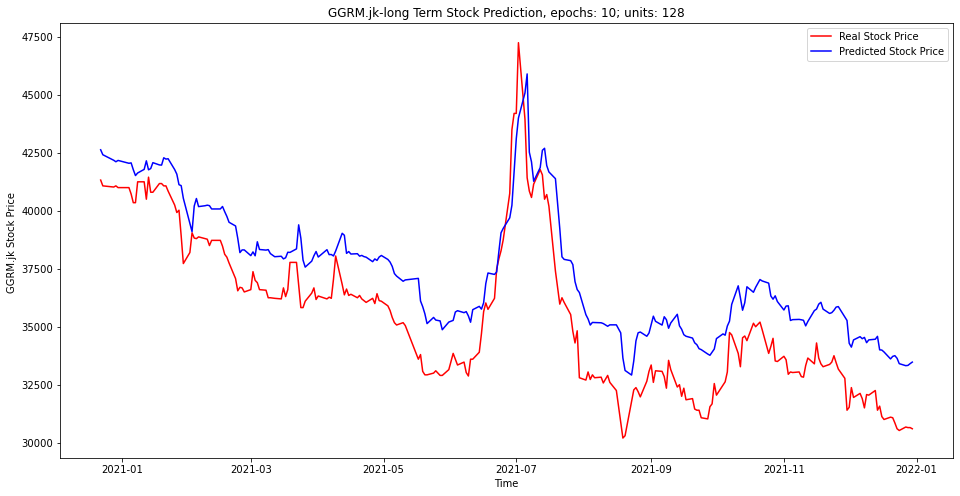

In [117]:
plt.figure()
plt.subplots(figsize=(16, 8))
plt.plot(df_union_zoom['y_test'], color = 'red', label = 'Real Stock Price')
plt.plot(df_union_zoom['y_pred'], color = 'blue', label = 'Predicted Stock Price')
plt.title(symbol_dataset +"-"+ term_status +' Term Stock Prediction, epochs: '+ str(epoch) +'; units: '+str(unit))
plt.xlabel('Time')
plt.ylabel(symbol_dataset +' Stock Price ')
plt.legend()

## Save a new Dataset

In [ ]:
# new_data = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'real_close'})
# new_data['close_lstm'] = y_pred

In [ ]:
# #save to dataset
# df_new_data = pd.DataFrame(new_data)

In [ ]:
# df_new_data.tail()

In [ ]:
# df_new_data.to_csv("../results/LSTM/datasets/" + index_dataset
#                 +'_LSTM-'+ term_status + '_e='+ str(epoch) +'_u='+ str(unit) + '.csv', index=True)

In [ ]:
# read_new_data = pd.read_csv("../results/LSTM/datasets/"+ term_status + symbol_dataset
#                    +'_LSTM-'+ term_status + '_e='+ str(epochs) +'_u='+ str(unit) + '.csv')
# read_new_data

## insert to Database

In [ ]:
# #connect database
# mydb = mysql.connect(
#     host="localhost",
#     user="root",
#     password="",
#     database="db_tugasakhir"
# )
# mycursor = mydb.cursor()

# #insert to database
# sql = "INSERT INTO pengujian_lstm (datasets, start_dates, end_dates,epochs, units, RMSE, MAE, MAPE) VALUES (%s,%s,%s,%s,%s,%s,%s,%s)"
# val = (symbol_dataset, start_date, end_date, epochs, unit, RMSE, MAE, MAPE)

# mycursor.execute(sql,val)
# mydb.commit()